# Model fitting

### Data model

In this example we discuss model fitting and show an example with CVXPY.
We are given data $(x_i,y_i)\in \mathcal X \times \mathcal Y$, $i=1, \ldots, m$:
* For $\mathcal X= {\bf R}^n$, $x$ is a *feature vector*.
* For $\mathcal Y= {\bf R}$,  $y$ is a (real) *outcome* or *label*.
* For $\mathcal Y= \{-1,1\}$,  $y$ is a (boolean) outcome.

Our goal is to find a *model* or *predictor*
$\psi: \mathcal X \to \mathcal Y$ so that
$\psi(x)\approx y$ *for data $(x,y)$ that we haven't seen*:
* For $\mathcal Y ={\bf R}$, $\psi$ is a *regression model*.
* For $\mathcal Y =\{-1,1\}$, $\psi$ is a *classifier*.

We choose $\psi$ based on observed data and prior knowledge.

### Loss minimization model

Let our data model be parametrized by $\theta\in {\bf R}^n$.
We define a *loss function*
$L: \mathcal X \times \mathcal Y \times {\bf R}^n \to {\bf R}$
where $L(x_i,y_i,\theta)$ is the loss (miss-fit) for the data point
$(x_i,y_i)$, using the model parameter $\theta$.

We choose $\theta$ to minimize the total loss $\sum_i L(x_i,y_i,\theta)$. Our model is then $\psi(x) = {\rm argmin}_y L(x,y,\theta)$.

### Model fitting via regularized loss minimization

An important concept in model fitting is *regularization* functions $r:{\bf R}^n \to {\bf R} \cup \{\infty\}$.
The function $r(\theta)$ measures model complexity, enforces
constraints, or represents a prior.

With regularization, we choose $\theta$ by minimizing the *regularized loss*

$$(1/m) \sum_i L(x_i,y_i,\theta)  + r(\theta).$$

For many useful cases, this is a convex problem.
Our model again is $\psi(x) = {\rm argmin}_y L(x,y,\theta)$.

### Example

In the following code we do an example of model fitting with CVXPY.
We are given (boolean) features $z\in \{0,1\}^{10}$ and (boolean) outcomes $y\in \{-1,1\}$.
We generate a new feature vector $x \in \{0,1\}^{55}$ which contains all products $z_iz_j$
(co-occurence of pairs of original features).

To fit our model, we use logistic loss, or $L(x,y,\theta) = \log (1+ \exp(-y\theta^T x))$, and an $\ell_1$ regularizer $r(\theta) = \|\theta\|_1$.
We train on $m=200$ examples and test on $100$ examples.
We plot the train and test error as we vary $\lambda$.

In [1]:
# Generate data for logistic model fitting problem.
import numpy as np

# Construct Z given X.
def pairs(Z):
    m, n = Z.shape
    k = n * (n + 1) // 2
    X = np.zeros((m, k))
    count = 0
    for i in range(n):
        for j in range(i, n):
            X[:, count] = Z[:, i] * Z[:, j]
            count += 1
    return X


np.random.seed(1)
n = 10
k = n * (n + 1) // 2
m = 200
TEST = 100
sigma = 1.9
DENSITY = 1.0
theta_true = np.random.randn(n, 1)
idxs = np.random.choice(range(n), int((1 - DENSITY) * n), replace=False)
for idx in idxs:
    theta_true[idx] = 0

Z = np.random.binomial(1, 0.5, size=(m, n))
Y = np.sign(Z.dot(theta_true) + np.random.normal(0, sigma, size=(m, 1)))
X = pairs(Z)
X = np.hstack([X, np.ones((m, 1))])
Z_test = np.random.binomial(1, 0.5, size=(TEST, n))
Y_test = np.sign(Z_test.dot(theta_true) + np.random.normal(0, sigma, size=(TEST, 1)))
X_test = pairs(Z_test)
X_test = np.hstack([X_test, np.ones((TEST, 1))])

In [2]:
# Form model fitting problem with logistic loss and L1 regularization.
import cvxpy as cp


theta = cp.Variable((k + 1, 1))
lambd = cp.Parameter(nonneg=True)
loss = cp.sum(
    cp.log_sum_exp(cp.hstack([np.zeros((m, 1)), -cp.multiply(Y, X @ theta)]), axis=1)
)
reg = cp.norm(theta[:k], 1)
prob = cp.Problem(cp.Minimize(loss / m + lambd * reg))

In [3]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-4, 0, TRIALS)
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(solver=cp.SCS)
    train_error[i] = (
        np.sign(Z.dot(theta_true)) != np.sign(X.dot(theta.value))
    ).sum() / m
    test_error[i] = (
        np.sign(Z_test.dot(theta_true)) != np.sign(X_test.dot(theta.value))
    ).sum() / TEST

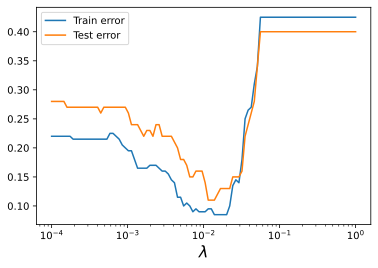

In [4]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

Below we plot $|\theta_{k}|$, $k=1,\ldots,55$, for the $\lambda$ that minimized the test error. Each $|\theta_{k}|$ is placed at position $(i,j)$ where $z_iz_j = x_k$. Notice that many $\theta_{k}$ are $0$, as we would expect with $\ell_1$ regularization.

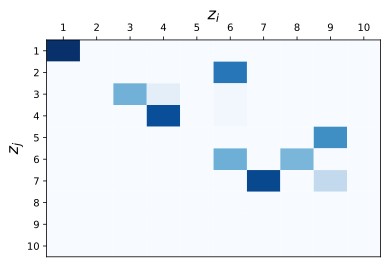

In [5]:
# Solve model fitting problem with the lambda that minimizes test error.
idx = np.argmin(test_error)
lambd.value = lambda_vals[idx]
prob.solve(solver=cp.SCS)

# Plot the absolute value of the entries in theta corresponding to each feature.
P = np.zeros((n, n))
count = 0
for i in range(n):
    for j in range(i, n):
        P[i, j] = np.abs(theta.value[count])
        count += 1
row_labels = range(1, n + 1)
column_labels = range(1, n + 1)

fig, ax = plt.subplots()
heatmap = ax.pcolor(P, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

plt.xlabel(r"$z_i$", fontsize=16)
ax.xaxis.set_label_position("top")
plt.ylabel(r"$z_j$", fontsize=16)
plt.show()